In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

# Directories for the images
benign_dir = "D:/M.Tech (IT)/SEM 3/Project/Phase 1/Kaggle_data/benignsegmented_final_SegNet_GA-20241117T152934Z-001/benignsegmented_final_SegNet_GA"
malignant_dir = "D:/M.Tech (IT)/SEM 3/Project/Phase 1/Kaggle_data/malignantsegmented_final_SegNet_GA-20241117T152929Z-001/malignantsegmented_final_SegNet_GA"

# Load and preprocess images
def load_images_from_folder(folder, label):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize to 128x128
            images.append((img, label))  # Append image and its label as tuple
    return images

# Data Augmentation
def augment_images(images, label):
    augmented_images = []
    for img, _ in images:
        # Horizontal flip
        flipped_img = cv2.flip(img, 1)
        augmented_images.append((flipped_img, label))
        
        # Rotation
        (h, w) = img.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, 15, 1.0)
        rotated_img = cv2.warpAffine(img, rotation_matrix, (w, h))
        augmented_images.append((rotated_img, label))
        
        # Brightness adjustment
        brightness_img = cv2.convertScaleAbs(img, alpha=1.1, beta=30)
        augmented_images.append((brightness_img, label))
        
        # Gaussian blur
        blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
        augmented_images.append((blurred_img, label))
        
        # Contrast adjustment
        contrast_img = cv2.convertScaleAbs(img, alpha=1.5, beta=0)
        augmented_images.append((contrast_img, label))
    
    return augmented_images

# Load images
benign_images = load_images_from_folder(benign_dir, 0)  # Label 0 for benign
malignant_images = load_images_from_folder(malignant_dir, 1)  # Label 1 for malignant

# Apply augmentation to both benign and malignant images
augmented_benign_images = augment_images(benign_images, 0)  # Label 0 for benign
augmented_malignant_images = augment_images(malignant_images, 1)  # Label 1 for malignant

# Combine original and augmented images
data = benign_images + augmented_benign_images + malignant_images + augmented_malignant_images
X, y = zip(*data)  # Unzip the list of tuples into separate lists
X = np.array(X)
y = np.array(y)

# Preprocess images for CNN
X_preprocessed = preprocess_input(X)

# Load pretrained VGG16 model (excluding the top classification layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features
features = feature_extractor.predict(X_preprocessed)
# Flatten features for Random Forest
X_features = features.reshape(features.shape[0], -1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)




In [7]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate precision, recall, specificity, and F1 score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, specificity, f1_score

In [ ]:
# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)



Accuracy: 89.3101%
Precision: 0.8860
Recall (Sensitivity): 0.8745
Specificity: 0.9083
F1 Score: 0.8802


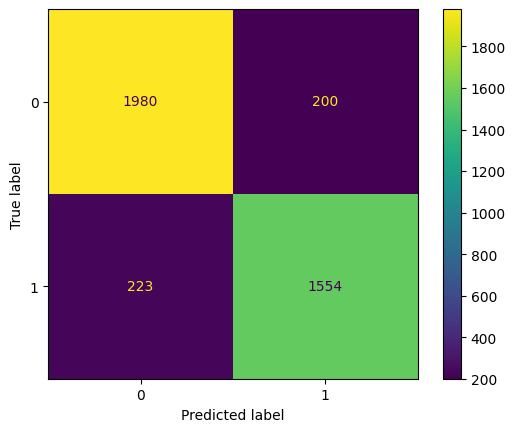

In [13]:

# Make predictions
y_pred = rf_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision, recall, specificity, f1_score = calculate_metrics(y_test, y_pred)

# Print metrics
print(f"Accuracy: {accuracy * 100:.4f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Train AdaBoost Classifier
ada_classifier = AdaBoostClassifier(
    n_estimators=100,  # Number of boosting stages
    learning_rate=1.0,  # Learning rate
    random_state=42
)
ada_classifier.fit(X_train, y_train)



###### Make predictions
y_pred = ada_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, specificity, f1_score = calculate_metrics(y_test, y_pred)

# Print metrics
print(f"Accuracy: {accuracy * 100:.4f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression Classifier
logistic_classifier = LogisticRegression(
    max_iter=1000,  # Increase iterations to ensure convergence
    random_state=42
)
logistic_classifier.fit(X_train, y_train)



Accuracy: 86.5807%
Precision: 0.8618
Recall (Sensitivity): 0.8351
Specificity: 0.8908
F1 Score: 0.8482


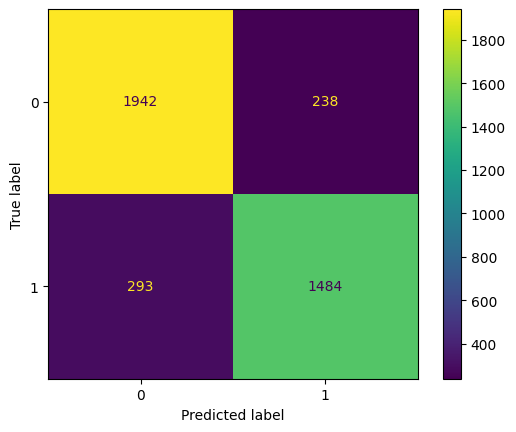

In [16]:
# Make predictions
y_pred = logistic_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision, recall, specificity, f1_score = calculate_metrics(y_test, y_pred)

# Print metrics
print(f"Accuracy: {accuracy * 100:.4f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [17]:
from sklearn.naive_bayes import GaussianNB

# Train Naive Bayes Classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)




GaussianNB()

Accuracy: 73.8185%
Precision: 0.8075
Recall (Sensitivity): 0.5476
Specificity: 0.8936
F1 Score: 0.6526


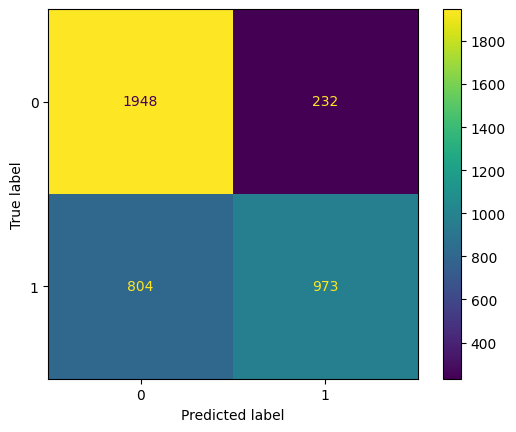

In [18]:
# Make predictions
y_pred = nb_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision, recall, specificity, f1_score = calculate_metrics(y_test, y_pred)

# Print metrics
print(f"Accuracy: {accuracy * 100:.4f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
